In [50]:
import tensorflow as tf
import os
import json
import functools
import pyvista as pv
import numpy as np
from utils import *

In [51]:
def plot_graph(data, l=1, plotter=None, node_colors=None):
    
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    # Création d'un PolyData pour les points (nœuds)
    mesh = pv.PolyData()
    
    # Gestion des dimensions des positions
    if data.pos.shape[1] != 3:
        # Ajouter une troisième dimension si nécessaire
        mesh.points = np.concatenate([data.pos.cpu().numpy(), np.full((data.pos.shape[0], 1), l)], axis=1)
    else:
        mesh.points = data.pos.cpu().numpy()

    # Création des lignes pour les arêtes
    edges = data.edge_index.t().cpu().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    
    
    # Ajout des couleurs au PolyData
    mesh.point_data['values'] = node_colors if node_colors is not None else np.random.randint(0, 255, size=(data.pos.shape[0], 3))
    
    # Ajouter le mesh avec les couleurs des nœuds
    p.add_mesh(mesh, scalars='values', line_width=0.5, point_size=0.3, render_points_as_spheres=True)

    # Si aucun plotter n'a été fourni, on montre la figure
    if plotter is None:
        p.show()

In [52]:
def _parse(proto, meta):
  """Parses a trajectory from tf.Example."""
  feature_lists = {k: tf.io.VarLenFeature(tf.string)
                   for k in meta['field_names']}
  features = tf.io.parse_single_example(proto, feature_lists)
  out = {}
  for key, field in meta['features'].items():
    data = tf.io.decode_raw(features[key].values, getattr(tf, field['dtype']))
    data = tf.reshape(data, field['shape'])
    if field['type'] == 'static':
      data = tf.tile(data, [meta['trajectory_length'], 1, 1])
    elif field['type'] == 'dynamic_varlen':
      length = tf.io.decode_raw(features['length_'+key].values, tf.int32)
      length = tf.reshape(length, [-1])
      data = tf.RaggedTensor.from_row_lengths(data, row_lengths=length)
    elif field['type'] != 'dynamic':
      raise ValueError('invalid data format')
    out[key] = data
  return out

def load_dataset(path, split):
  """Load dataset."""
  with open(os.path.join(path, 'meta.json'), 'r') as fp:
    meta = json.loads(fp.read())
  ds = tf.data.TFRecordDataset(os.path.join(path, split+'.tfrecord'))
  ds = ds.map(functools.partial(_parse, meta=meta), num_parallel_calls=8)
  ds = ds.prefetch(1)
  return ds

In [53]:
train_ds = load_dataset("../DATA/cylinder_flow", 'train')
val_ds = load_dataset("../DATA/cylinder_flow", 'valid')
test_ds = load_dataset("../DATA/cylinder_flow", 'test')

In [54]:
from torch_geometric.data import Data
import torch
from utils import  DelaunayTransform
from torch_geometric.loader import DataLoader


In [ ]:
def prepare_dataset(ds):
    transform = DelaunayTransform()
    dataset = []
    for i, obs in enumerate(ds):
        new_obs = {}
        for key, value in obs.items():
            if 'mesh' in key or 'cells' in key or 'node_type' in key:
                key = key.replace('mesh_', '')
                new_obs[key] = torch.Tensor(value[0].numpy())
            else:
                new_obs["x_" + key] = torch.Tensor(value[0].numpy())
                new_obs["y_" + key] = torch.Tensor(value[-1].numpy())
        surf = torch.Tensor((obs['velocity'][0][:] == 0.0).numpy())
        surf = torch.logical_and(surf[:, 0], surf[:, 1])
        x = torch.cat([new_obs['x_velocity'], new_obs['x_pressure'], surf.unsqueeze(1)], dim=1)
        y = torch.cat([new_obs['y_velocity'], new_obs['y_pressure']], dim=1)
        data = transform(Data(pos=new_obs["pos"], surf=surf, x=x, y=y))
        data = generate_coarse_graphs(data, 3, 4)
        dataset.append(data)
    data_loader = DataLoader(dataset=dataset, batch_size=1)
    return data_loader
train_loader = prepare_dataset(train_ds)
val_loader = prepare_dataset(val_ds)
test_loader = prepare_dataset(test_ds)

In [56]:
import importlib
import utils
importlib.reload(utils)
import my_model
from utils import *

In [57]:
#plot_graph(generate_coarse_graphs(next(iter(data_loader)), R=3, K=4, visualize=True))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [58]:
model = my_model.UaMgnn(4, 3, 3, 4, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
model = model.to(device)

In [59]:
def validate(model, loader, device):
    model.eval()
    loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            loss += torch.nn.functional.mse_loss(out, data.y).item()
    return loss / len(loader)

In [60]:
import matplotlib.pyplot as plt

validation_losses = []
train_losses = []
for epoch in range(30):
    loss_av = 0
    i = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        if torch.isnan(out).any():
            print("Nan")
        loss = torch.nn.functional.mse_loss(out, data.y)
        loss_av += loss.item()
        i += 1
        loss.backward()
        optimizer.step()
    train_losses.append(loss_av/i)
    validation_losses.append(validate(model, val_loader, device))
    print(f"Epoch {epoch} Loss {loss_av/i}")
    print(f"Validation Loss {validation_losses[-1]}")
    


Epoch 0 Loss 216894847732.9645
Validation Loss 0.5129957772791386
Epoch 1 Loss 4.80665404734388
Validation Loss 0.26913256280124187
Epoch 2 Loss 1.717683525737375
Validation Loss 0.15538251776248216
Epoch 3 Loss 0.12903602707013487
Validation Loss 0.13484638530761003
Epoch 4 Loss 0.10460363282635808
Validation Loss 0.10504118131473661
Epoch 5 Loss 0.08851956943888217
Validation Loss 0.09086354845203459
Epoch 6 Loss 0.07944152347557247
Validation Loss 0.08109729142859579
Epoch 7 Loss 0.0718166169906035
Validation Loss 0.07569640341214835
Epoch 8 Loss 0.06760459430748597
Validation Loss 0.07161032740958034
Epoch 9 Loss 0.06375341420248151
Validation Loss 0.06668177452404052
Epoch 10 Loss 0.05938624323485419
Validation Loss 0.0638735518977046
Epoch 11 Loss 0.05694434650242328
Validation Loss 0.06146750858053565
Epoch 12 Loss 0.054673752491828057
Validation Loss 0.05940696375910193
Epoch 13 Loss 0.052282247671857476
Validation Loss 0.0563124689180404
Epoch 14 Loss 0.0487830593700055
Valida

In [61]:
validate(model, test_loader, device)

7.306873871516757e+31

(0.0, 0.1)

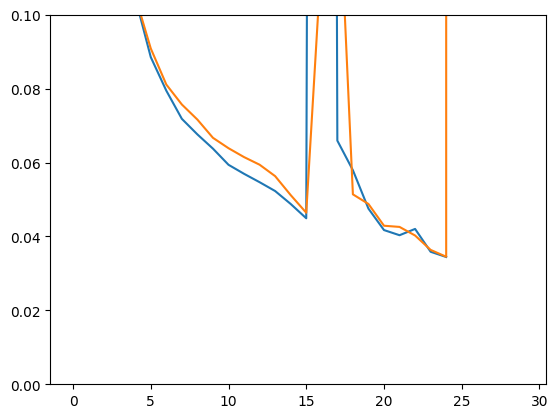

In [62]:
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.ylim(0, 0.1)